# Parametric Circuit Fitting Belem

In [61]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [86]:
def fit_model(filename, rank):
    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/{filename}.p", "rb"))
    
    N_map = inputs_map[0].shape[0]

    targets_map = counts_to_probs(counts_list[:N_map])
    targets_spam = counts_to_probs(counts_list[N_map:])
    
    d = targets_map.shape[1]
    n = int(np.log2(d))

    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=rank,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                )
    return model

In [63]:
def regularized_fit(d, data, num_iter_spam=1000, num_iter_map=2000, N=500, weight=1, start = 2):
    
    inputs_spam, targets_spam, inputs_map, targets_map = data
    
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = num_iter_spam,
               verbose = False,
              )
    model_fullrank = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=d**2,
                                               spam = spam,
                                               ),
                                     loss_function = ProbabilityMSE(),
                                     optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                     logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                                    )

    model_fullrank.train(inputs = inputs_map,
                         targets = targets_map,
                         num_iter = num_iter_map,
                         N = N,
                        )
    
    loss_ref = model_fullrank.logger.loss_train_list[-1]
    
    for rank in range(start, d**2):
        if rank == start:
            loss_prev = 1000
            
        model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=rank,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

        model.train(inputs = inputs_map,
                    targets = targets_map,
                    num_iter = num_iter_map,
                    N = N,
                    )
        
        loss = model.logger.loss_train_list[-1]
        if (rank)/(rank-1) > (loss_prev - loss_ref)/(loss - loss_ref):
            break
        model_final = model
        loss_prev = loss   
    
    return model_final

In [111]:
def spectrum_to_radial(spectrum):
    radial = tf.norm(spectrum, axis=1)
    return radial

def spectrum_to_angular(spectrum):
    angular = tf.math.angle(spectrum, axis=1)
    return angular

def find_outer_inner_R(spectrum_list):
    L = len(spectrum_list)
    radial_list = np.array([np.sort(spectrum_to_radial(spectrum)) for spectrum in spectrum_list])
    R_minus = np.mean(radial_list[:,0])
    R_minus_std = np.std(radial_list[:,0])
    R_plus = np.mean(radial_list[:,-1])
    R_plus_std = np.std(radial_list[:,-1])
    return R_plus, R_minus, R_plus_std, R_minus_std

## No Delay

In [88]:
model1_list = []

for i in range(10):
    model = fit_model(f"twoQubits_PQC_noDelay_belem_{i}", rank=16)
    model1_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

8.278664410473552e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0016944687764660893


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0018338228327973492 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00016848899402171726


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0022642561187598445


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0015785823471428644 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00020551273465563267


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0019014134316946113


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0018956894497678218 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00010316205916986788


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00397470359232599


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003675152131206154 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.913069366296323e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002971639832664837


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0036390303302244547 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0028162497916000236


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002237101349978524


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003248274717907787 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00010528136153624094


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002733821571132925


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00374430334937188 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00010509146117741985


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0032835949117384074


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0037074180500626056 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00032322859358197313


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002609367946236214


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003371646331286629 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00013979513087470228


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003485982694321382


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003171223256874395 None


In [89]:
model2_list = []

for i in range(10):
    model = fit_model(f"twoQubits_PQC_5usDelay_belem_{i}", rank=16)
    model2_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

0.0004407382363276489


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0026740968169600993


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027275865213598717 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00023768402857463267


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0029401494775238737


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0033647894080219036 None


  0%|          | 0/300 [00:00<?, ?it/s]

9.797343301880317e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003039758983481851


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034108715721787508 None


  0%|          | 0/300 [00:00<?, ?it/s]

7.028208324827344e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003188688788533001


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0031367738948888477 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00019267331695926328


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0026063089186316277


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003063826740438469 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0003172800526087073


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003941982504805837


  0%|          | 0/2000 [00:00<?, ?it/s]

0.1800100483710783 None


  0%|          | 0/300 [00:00<?, ?it/s]

8.614156272682301e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027678989704347807


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003205306085844034 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00036058891202132897


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00279941447532792


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002861081562183638 None


  0%|          | 0/300 [00:00<?, ?it/s]

5.2058407265221854e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0036697812427301715


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027652639835367724 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00014727476346627243


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0032114988636374217


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030547271264203322 None


In [90]:
model3_list = []

for i in range(10):
    model = fit_model(f"twoQubits_PQC_10usDelay_belem_{i}", rank=16)
    model3_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

0.00011888288864230235


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003843317209643455


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0028423786939366104 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00347894631347752


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003145648600975188


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002824178370590368 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0024573722222130953


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002414467908634536


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002729519996811828 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00026237302176855646


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0028281600759250823


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002698391461200707 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00014226033493758332


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0019409318879450414


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027227790166691164 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0001970138064465128


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004494811993839411


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002827069359859849 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00010862947958589952


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004159861222325996


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0032177249989244964 None


  0%|          | 0/300 [00:00<?, ?it/s]

6.191235105720928e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002736158907156655


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030325976525741863 None


  0%|          | 0/300 [00:00<?, ?it/s]

7.717901323254348e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003712088625602094


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0029592048449393004 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0024900132333449667


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003262254084441303


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002405421394312349 None


In [91]:
model4_list = []

for i in range(10):
    model = fit_model(f"twoQubits_PQC_15usDelay_belem_{i}", rank=16)
    model4_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

4.694637662136239e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002963400205282556


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0024900496838539334 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00013025374093330466


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030439039604009993


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003914087607305095 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0002099359073486418


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0032689363948646194


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00253301910265739 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0003270870616363983


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0033129562049266925


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004214367326541008 None


  0%|          | 0/300 [00:00<?, ?it/s]

6.086344840834576e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0022089056569862572


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0025563452191485407 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0001230656151302172


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004130792818008391


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003101483082455081 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.008275816026631634


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030812411286179043


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005061110777731732 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00015428400608962902


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003286406037319149


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002980372824803505 None


  0%|          | 0/300 [00:00<?, ?it/s]

7.2123447326526e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0028056292578590354


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002980258386317972 None


  0%|          | 0/300 [00:00<?, ?it/s]

5.268757287852062e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0028877670211712348


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00600445297948262 None


In [92]:
model5_list = []

for i in range(10):
    model = fit_model(f"twoQubits_PQC_20usDelay_belem_{i}", rank=16)
    model5_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

0.0002490013581520759


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00471826818801508


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0037597146758332326 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00021959429184565876


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0038872891674473736


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034272806074824493 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0007318123673776695


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003162214211982072


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0032034707650503568 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0004103370712338772


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0025315245394541843


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005714722889913059 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00017418622862018114


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002932124899560546


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030474166040440082 None


  0%|          | 0/300 [00:00<?, ?it/s]

9.49792765597587e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0038026681587936323


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011851193363802859 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00016128153257832263


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0030757461695456075


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002625992308342519 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0007367856909253584


  0%|          | 0/2000 [00:00<?, ?it/s]

0.004189645870829056


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002930918770542014 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00028343646031472604


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0019823563707001435


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0034460227981912128 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00018817179247361372


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002677034328544726


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00437873124816894 None


In [93]:
model6_list = []

for i in range(10):
    model = fit_model(f"twoQubits_PQC_25usDelay_belem_{i}", rank=8)
    model6_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

0.00018295677995185968


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002745215830043874


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0027596324780314227 None


  0%|          | 0/300 [00:00<?, ?it/s]

7.984048622863038e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0032081441248874003


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002692571701734436 None


  0%|          | 0/300 [00:00<?, ?it/s]

6.837842968917582e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003318628727056691


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0026176620044245573 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0003239577685833851


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0029493164213576723


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003283972432638723 None


  0%|          | 0/300 [00:00<?, ?it/s]

7.962329482779208e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.003850386962426379


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002660875489621865 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.0001354705927803547


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0035589752655148226


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002809631226300553 None


  0%|          | 0/300 [00:00<?, ?it/s]

0.00010187534114727082


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002209580515155364


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0023356760973381957 None


  0%|          | 0/300 [00:00<?, ?it/s]

5.507908484135332e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0022043328475809514


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0033606894093348647 None


  0%|          | 0/300 [00:00<?, ?it/s]

5.6167845214167704e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0017479395623851166


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0024538490217716176 None


  0%|          | 0/300 [00:00<?, ?it/s]

6.975410695139895e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0039622557186356384


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0041151545123088796 None


In [112]:
data1 = [model.channel for model in model1_list]
data2 = [model.channel for model in model2_list]
data3 = [model.channel for model in model3_list]
data4 = [model.channel for model in model4_list]
data5 = [model.channel for model in model5_list]
data6 = [model.channel for model in model6_list]

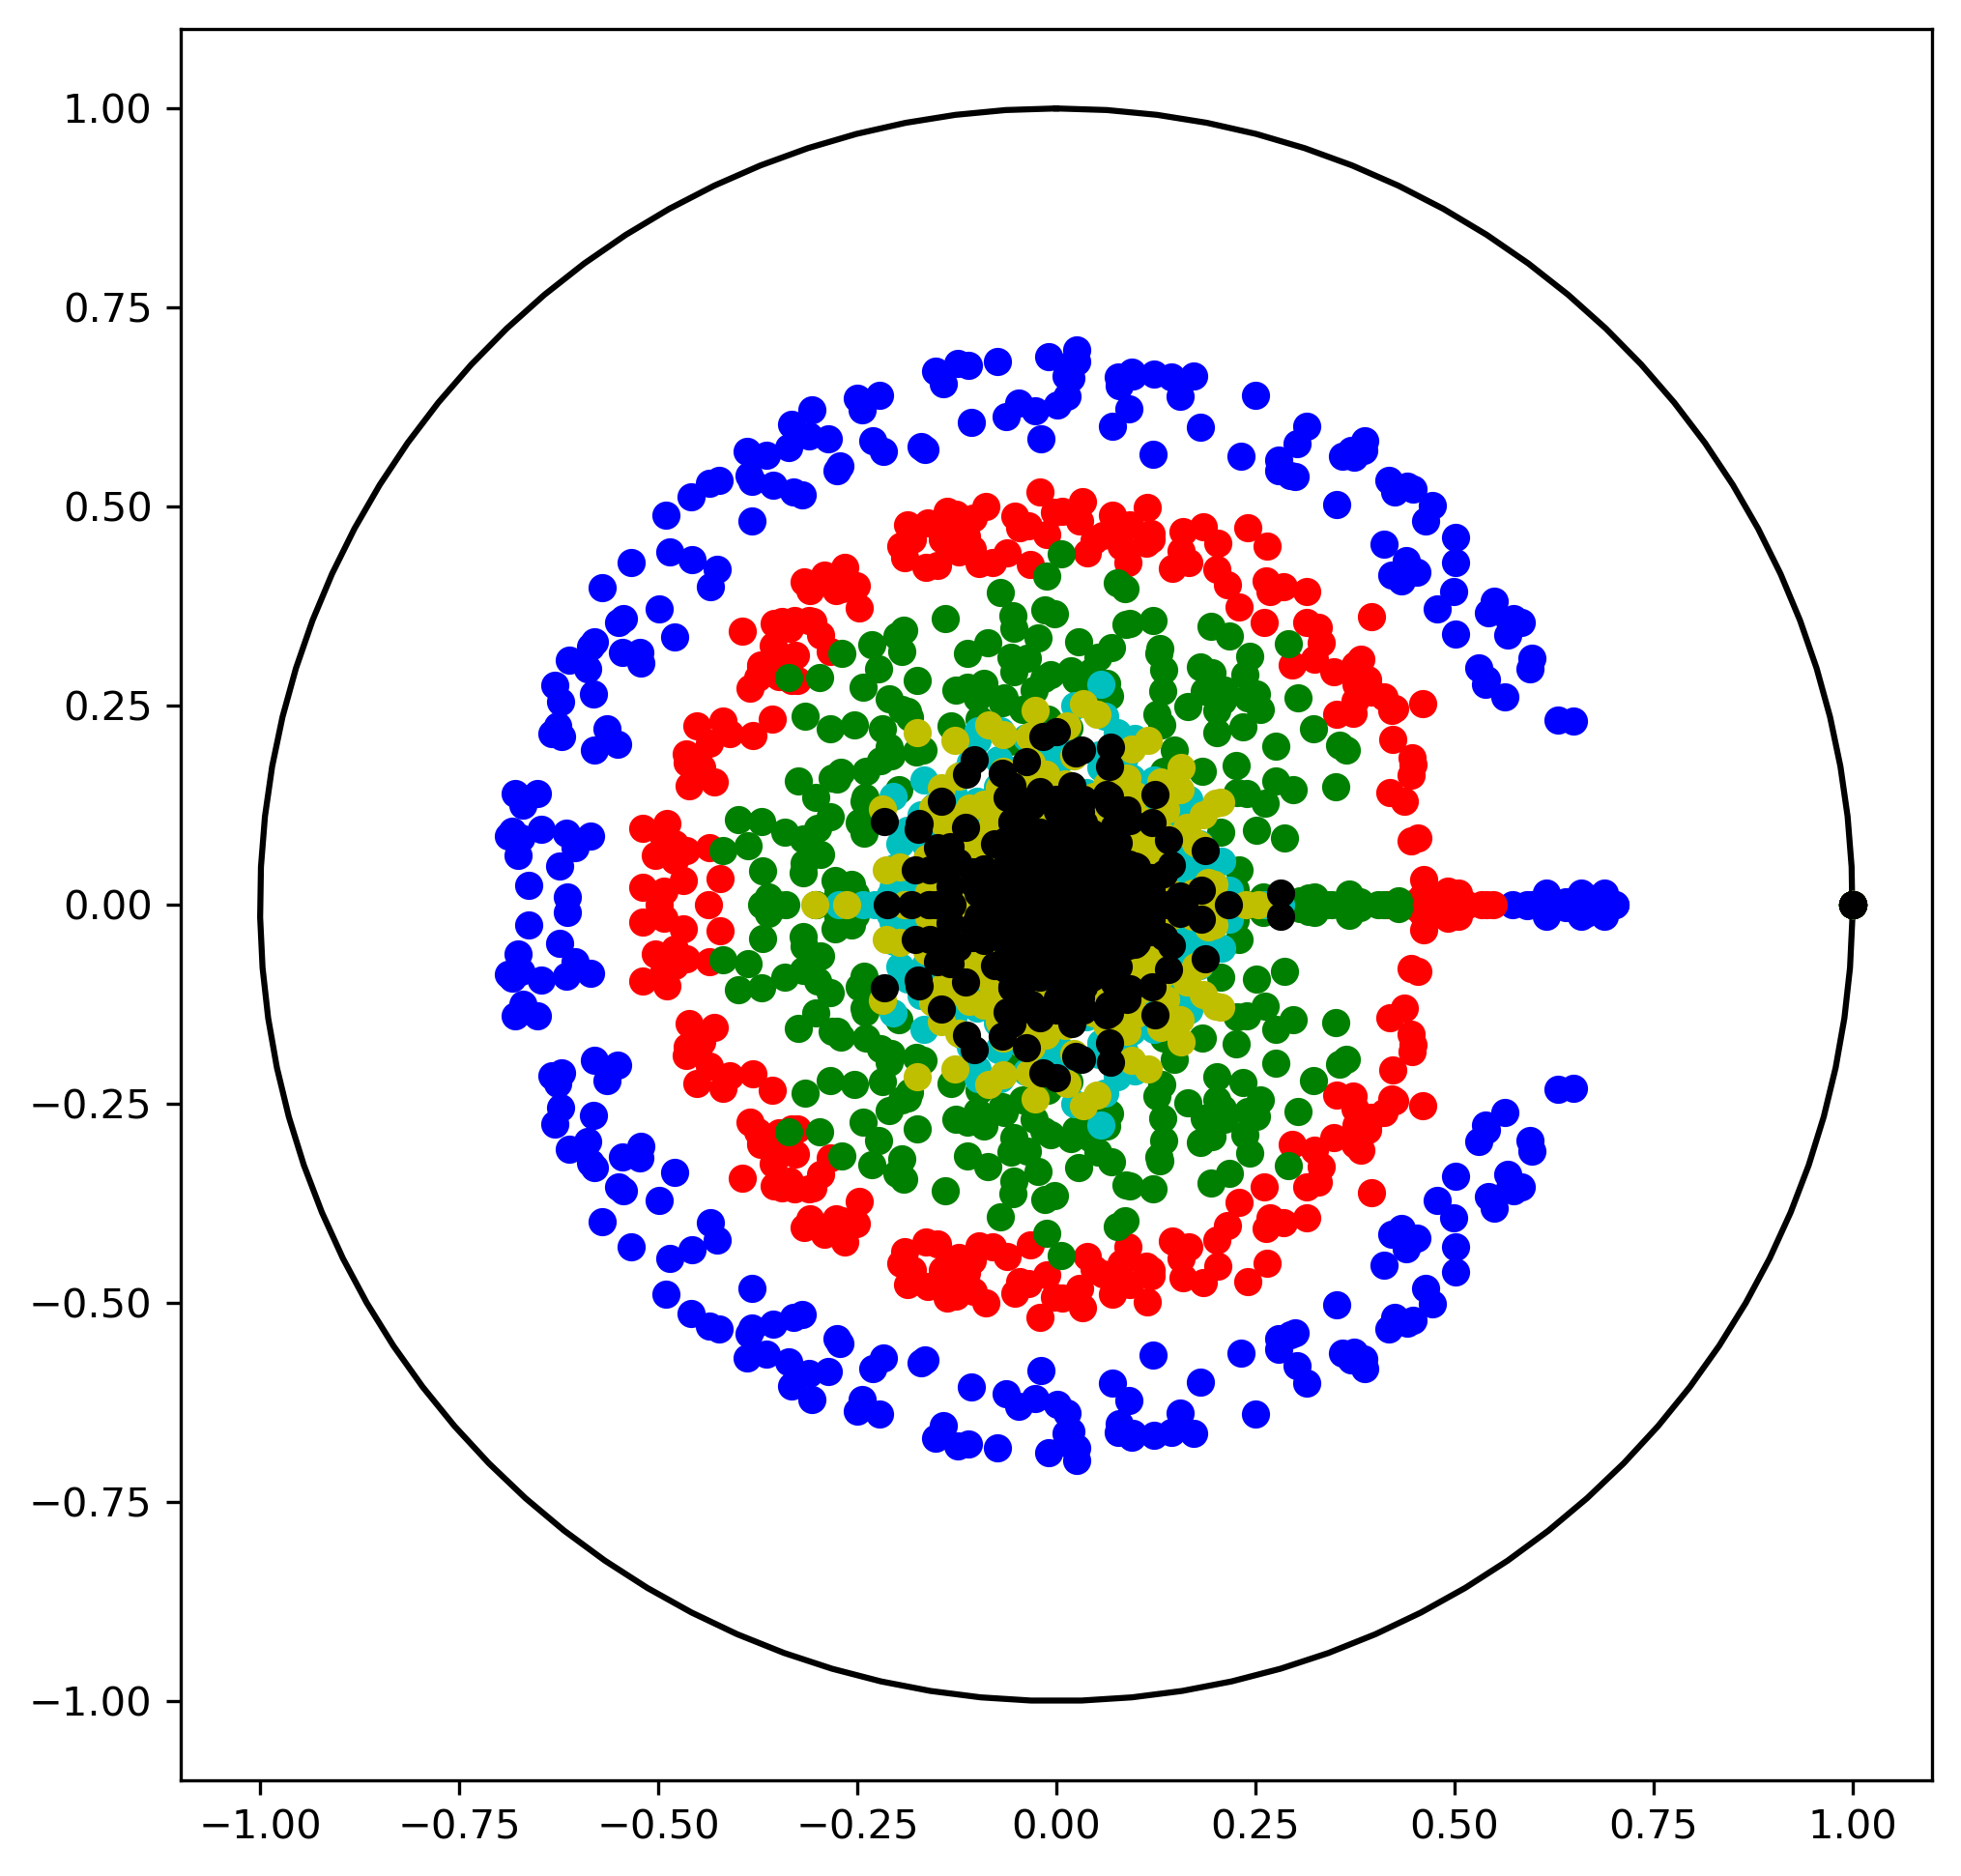

In [113]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

spectrum1_list = [channel_spectrum(channel) for channel in data1]
spectrum2_list = [channel_spectrum(channel) for channel in data2]
spectrum3_list = [channel_spectrum(channel) for channel in data3]
spectrum4_list = [channel_spectrum(channel) for channel in data4]
spectrum5_list = [channel_spectrum(channel) for channel in data5]
spectrum6_list = [channel_spectrum(channel) for channel in data6]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum1_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")

for spectrum in spectrum2_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")

for spectrum in spectrum3_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "go")

for spectrum in spectrum4_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "co")

for spectrum in spectrum5_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "yo")

for spectrum in spectrum6_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "ko")

plt.show()

In [78]:
R_p1, R_m1, R_pStd1, R_mStd1 = find_outer_inner_R([spectrum1_list[i][:-1] for i in range(5)])
R_p2, R_m2, R_pStd2, R_mStd2 = find_outer_inner_R([spectrum2_list[i][:-1] for i in range(5)])
R_p3, R_m3, R_pStd3, R_mStd3 = find_outer_inner_R([spectrum3_list[i][:-1] for i in range(5)])
R_p4, R_m4, R_pStd4, R_mStd4 = find_outer_inner_R([spectrum4_list[i][:-1] for i in range(5)])
R_p5, R_m5, R_pStd5, R_mStd5 = find_outer_inner_R([spectrum5_list[i][:-1] for i in range(5)])
R_p6, R_m6, R_pStd6, R_mStd6 = find_outer_inner_R([spectrum6_list[i][:-1] for i in range(5)])

In [79]:
x = [0, 5, 10, 15, 20, 25]
R_plus = [R_p1, R_p2, R_p3, R_p4, R_p5, R_p6]
R_minus = [R_m1, R_m2, R_m3, R_m4, R_m5, R_m6]
R_plus_std = [R_pStd1, R_pStd2, R_pStd3, R_pStd4, R_pStd5, R_pStd6]
R_minus_std = [R_mStd1, R_mStd2, R_mStd3, R_mStd4, R_mStd5, R_mStd6]

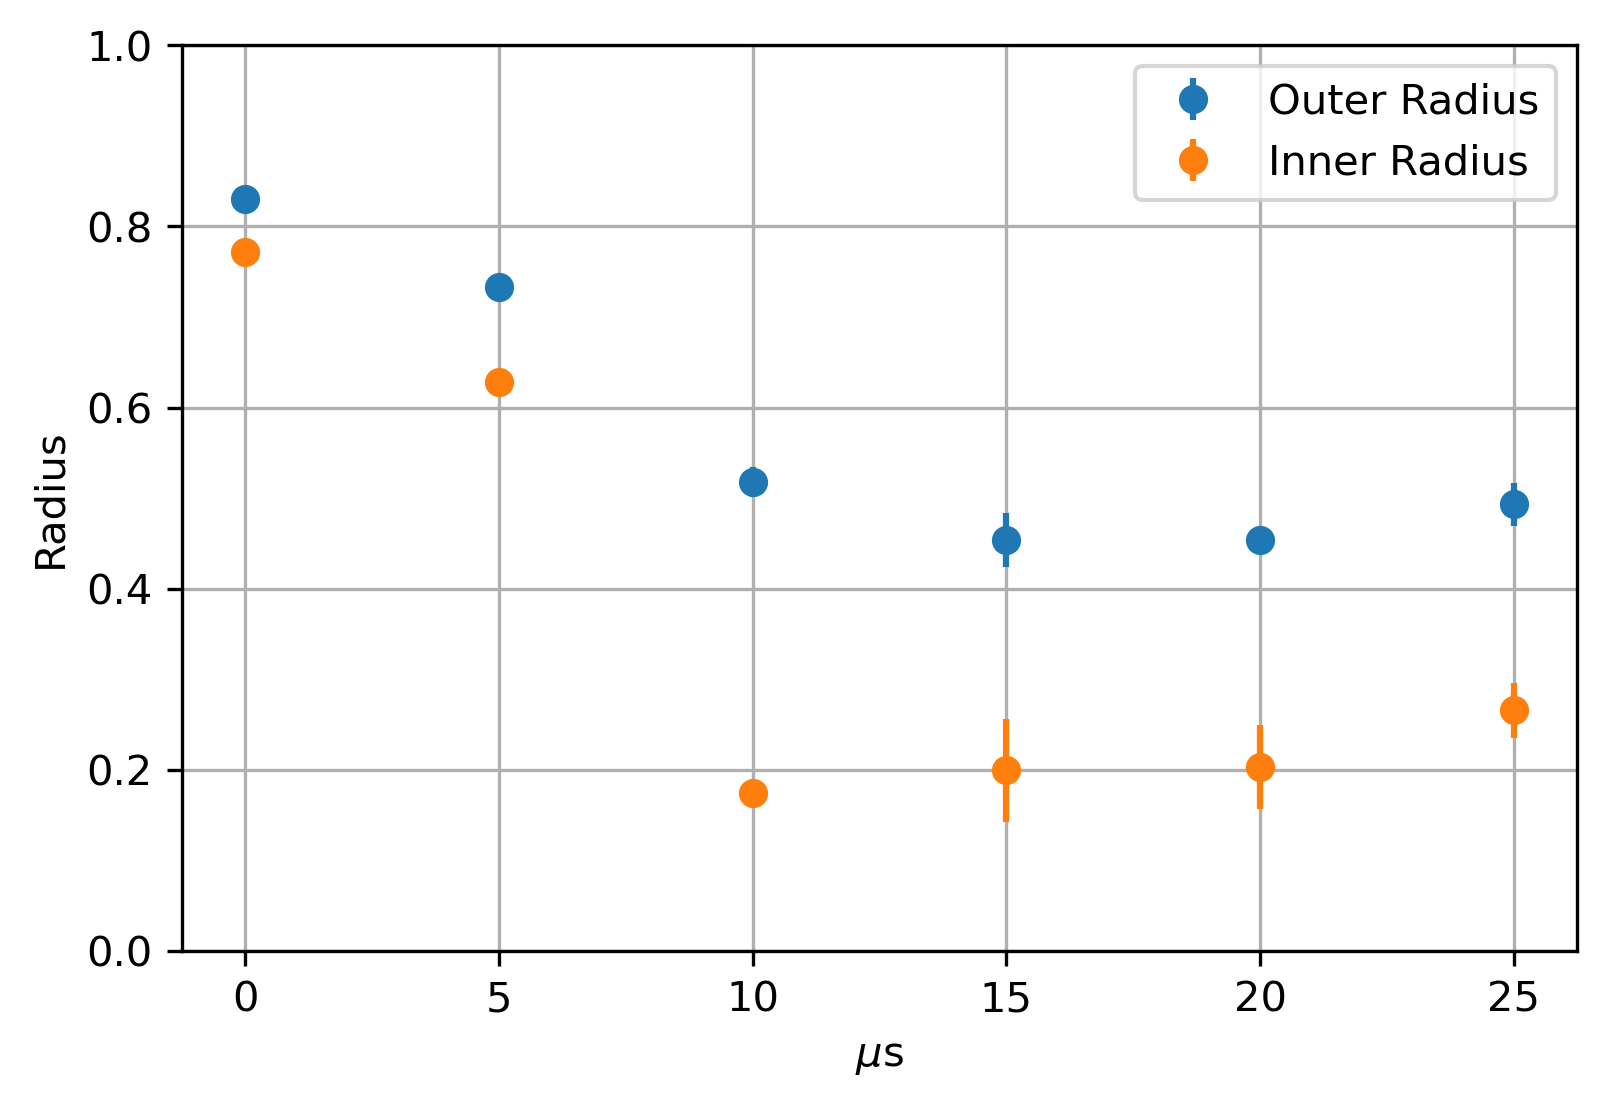

In [80]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, R_plus, yerr=R_plus_std, fmt="o")
plt.errorbar(x, R_minus, yerr=R_minus_std, fmt="o")
plt.ylim([0,1])
plt.grid()
plt.xlabel("$\mu$s")
plt.ylabel("Radius")
plt.legend(["Outer Radius", "Inner Radius"])
plt.show()

## No Delay

In [95]:
n = 3
d = 2**n

model1_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list = pickle.load(open(f"../../data/threeQubits_PQC_noDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500)
    
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=64,
                                               spam = spam,
                                               ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                N = 500,
                )
    model1_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009294610242723034


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006698431304911873 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00883082130712961


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007033265647107129 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010011850389418665


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0070736153367333835 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008457467700971812


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0063809113707714304 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008652212196433992


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00905535485041568 None


## 5 us Delay

In [96]:
n = 3
d = 2**n

model2_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_5usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 15)
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=64,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                N = 500,
                )
    model2_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0090221323813562


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006871131851613309 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008922262113598799


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008218067751977823 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00894339530238664


  0%|          | 0/2000 [00:00<?, ?it/s]

0.007548555570412688 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008727108177318872


  0%|          | 0/2000 [00:00<?, ?it/s]

0.04444230583800551 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00949880907775906


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0073256950929622205 None


## 10 us Delay

In [97]:
n = 3
d = 2**n

model3_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_10usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 15)
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=64,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                N = 500,
                )
    model3_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009452276313614005


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00770113125577257 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010464463897493241


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008390326790176017 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009232564129990854


  0%|          | 0/2000 [00:00<?, ?it/s]

0.010592111838409347 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008838218067504457


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0087653868485887 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009040883469836232


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011092830155728779 None


# 15 us Delay

In [98]:
n = 3
d = 2**n

model4_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_15usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 15)
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=64,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                N = 500,
                )
    model4_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009289253758265082


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013790804886450389 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008676500147706474


  0%|          | 0/2000 [00:00<?, ?it/s]

0.014367325255387675 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008747928510555492


  0%|          | 0/2000 [00:00<?, ?it/s]

0.018028061297263753 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.005445035025984117


  0%|          | 0/2000 [00:00<?, ?it/s]

0.006867566794851911 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00873348666948159


  0%|          | 0/2000 [00:00<?, ?it/s]

0.008193770105672371 None


# 20 us Delay

In [99]:
n = 3
d = 2**n

model5_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_20usDelay_belem_{i}_retry.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 25)
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=64,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                N = 500,
                )
    model5_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009075343275063784


  0%|          | 0/2000 [00:00<?, ?it/s]

0.020227309982139532 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00963680401353413


  0%|          | 0/2000 [00:00<?, ?it/s]

0.020424247953654984 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00829239494521509


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013969640535634159 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009116836096757107


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01386798417494706 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009413836078073112


  0%|          | 0/2000 [00:00<?, ?it/s]

0.019470402618625322 None


# 25 us Delay

In [100]:
n = 3
d = 2**n

model6_list = []

for i in range(5):

    inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_PQC_25usDelay_belem_{i}.p", "rb"))

    targets_map = counts_to_probs(counts_list[:2000-6**n])
    targets_spam = counts_to_probs(counts_list[2000-6**n:])

    data = [inputs_spam, targets_spam, inputs_map, targets_map]

    np.random.seed(42)
    random.seed(42)
    tf.random.set_seed(42)

    #model = regularized_fit(d, data, num_iter_spam=1000, num_iter_map = 2000, N = 500, start = 25)
    spam = SPAM(d=d, 
                use_corr_mat = True,
                optimizer = tf.optimizers.Adam(learning_rate=0.01),
                )
    
    spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                  num_iter = 300,
                  verbose = False,
                  )
    
    spam.train(inputs = inputs_spam,
               targets = targets_spam,
               num_iter = 2000,
               verbose = False,
              )
    
    model = ModelQuantumMap(channel = KrausMap(d=d, 
                                                   rank=64,
                                                   spam = spam,
                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                               )

    model.train(inputs = inputs_map,
                targets = targets_map,
                num_iter = 2000,
                N = 500,
                )
    model6_list.append(model)

  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.011882567527369816


  0%|          | 0/2000 [00:00<?, ?it/s]

0.02228272824527496 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009232401535037169


  0%|          | 0/2000 [00:00<?, ?it/s]

0.013525020452766025 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009333734029221021


  0%|          | 0/2000 [00:00<?, ?it/s]

0.01915726635344709 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009679994022759921


  0%|          | 0/2000 [00:00<?, ?it/s]

0.03440800201498308 None


  0%|          | 0/300 [00:00<?, ?it/s]

3.806583148768781e-05


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00884436034276346


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00751173275026462 None


In [101]:
data1 = [model.channel for model in model1_list]
data2 = [model.channel for model in model2_list]
data3 = [model.channel for model in model3_list]
data4 = [model.channel for model in model4_list]
data5 = [model.channel for model in model5_list]
data6 = [model.channel for model in model6_list]

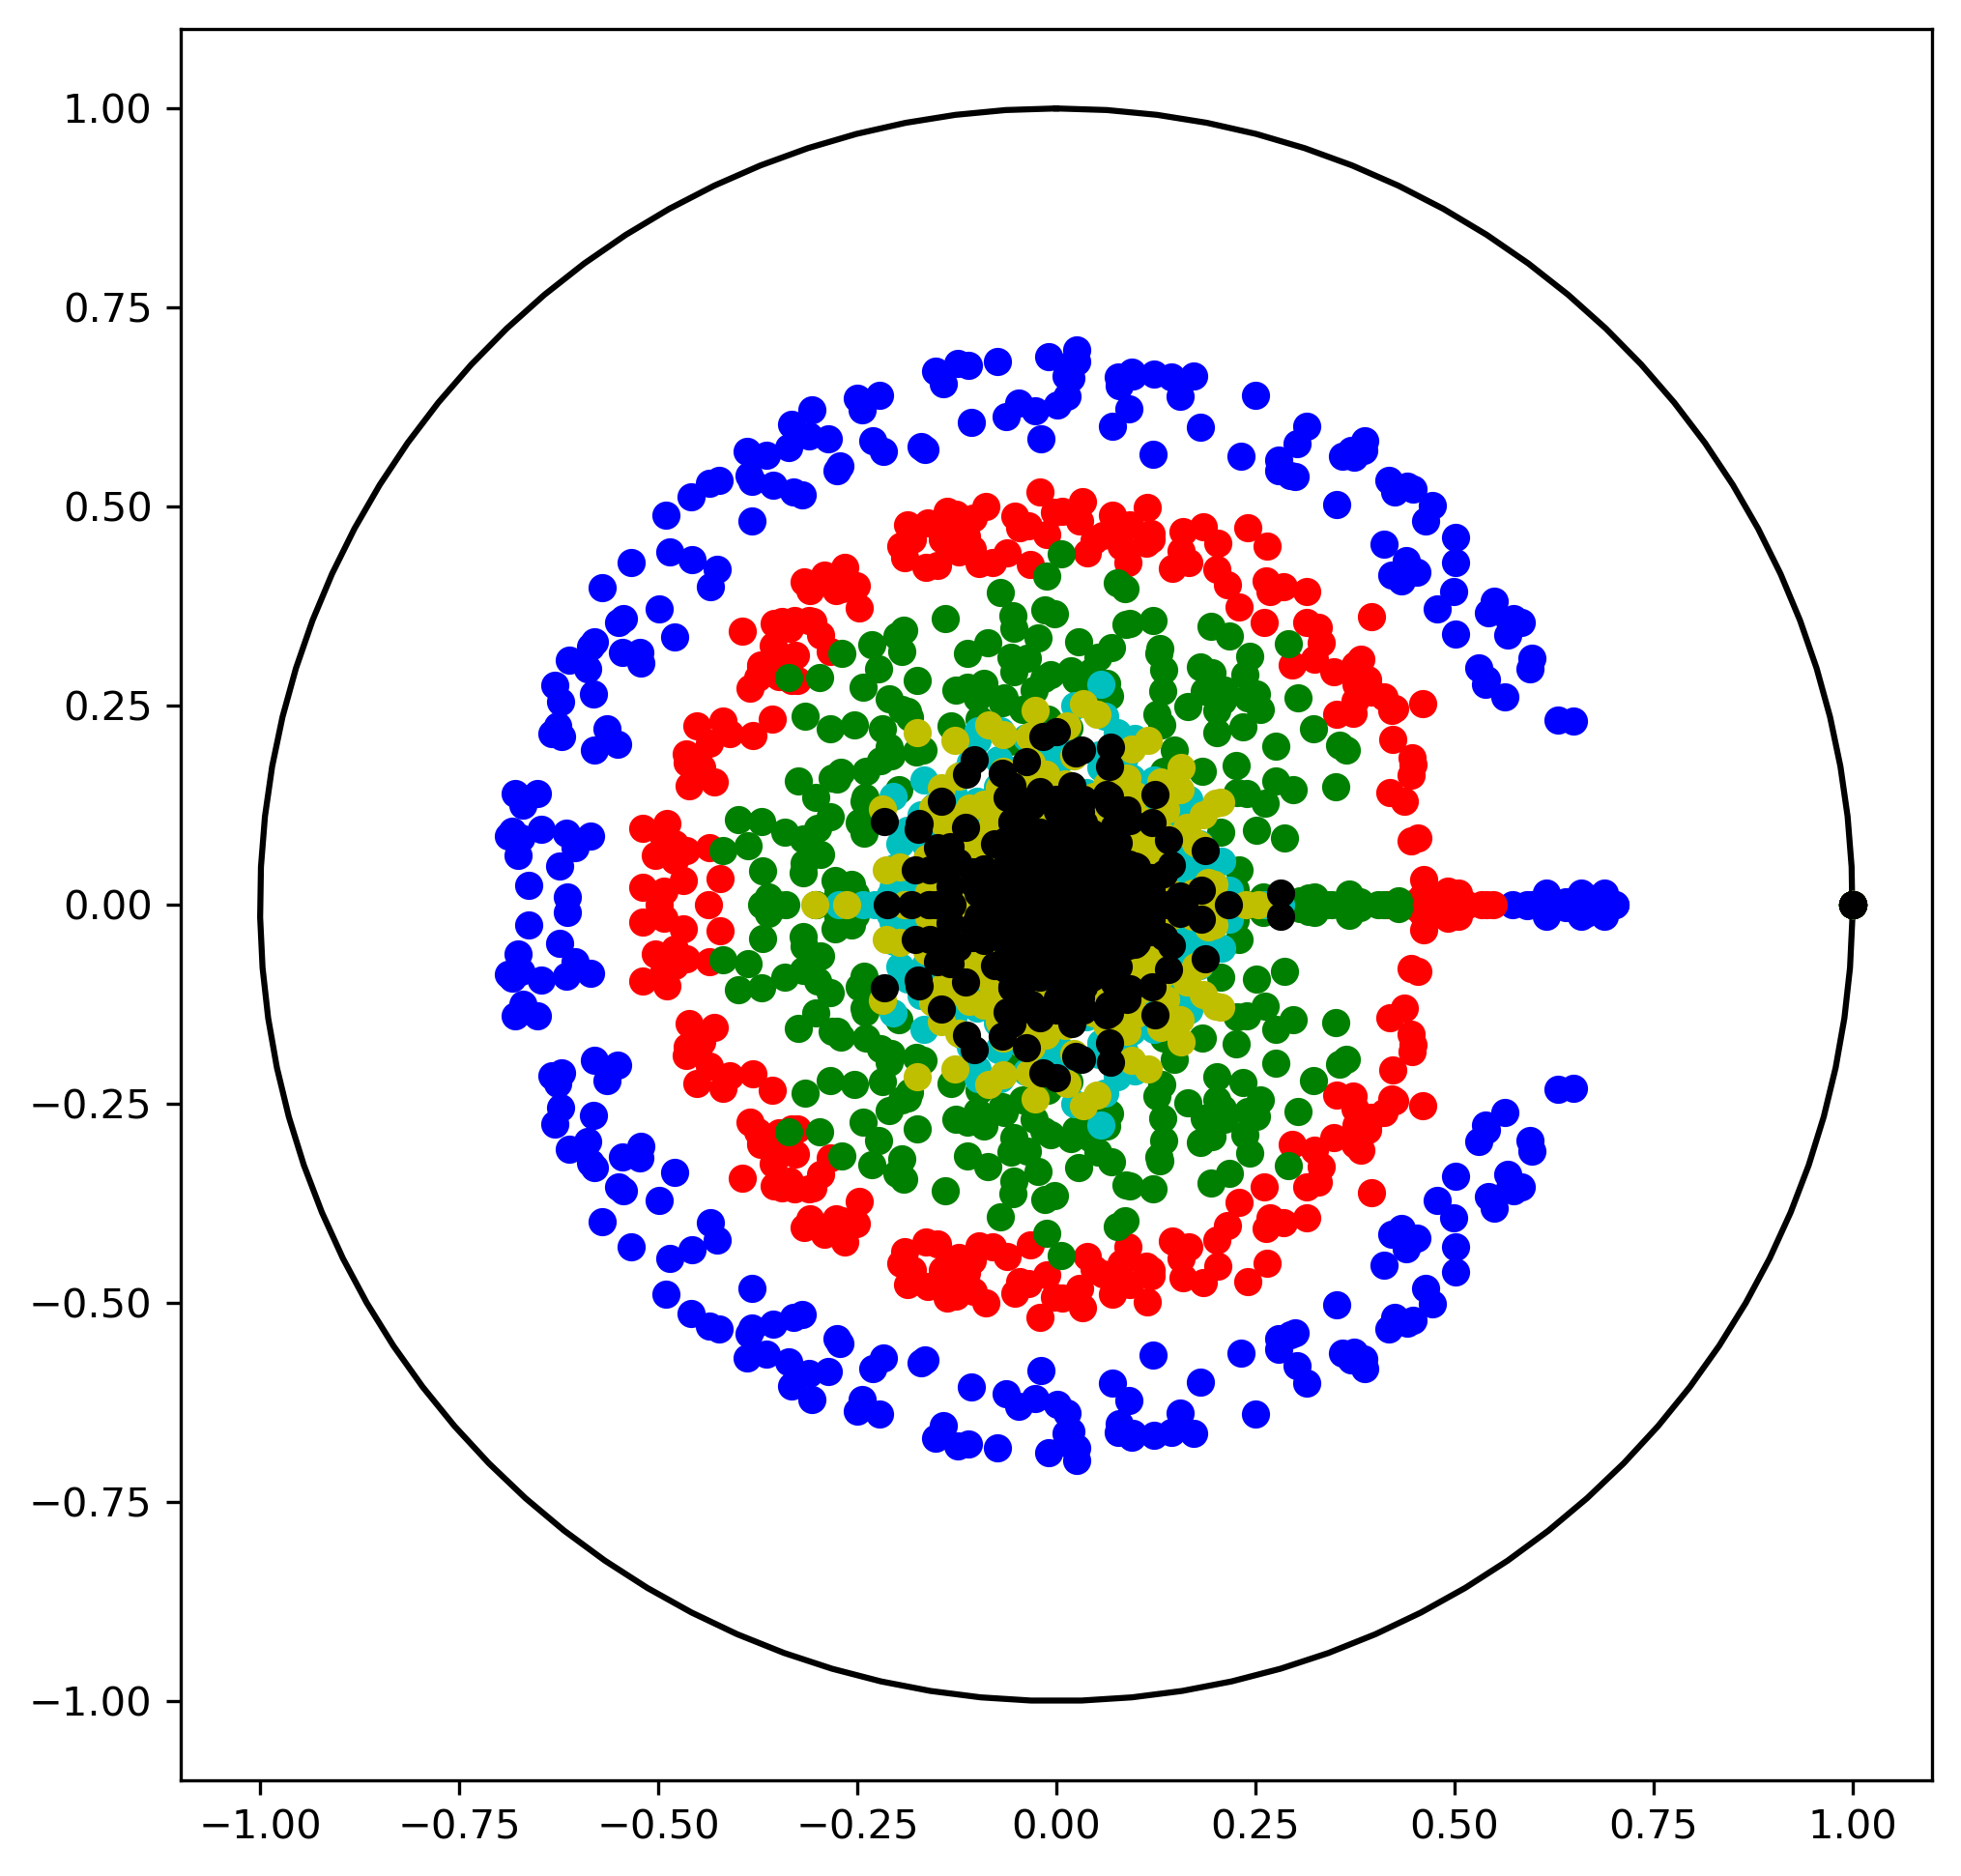

In [102]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]

spectrum1_list = [channel_spectrum(channel) for channel in data1]
spectrum2_list = [channel_spectrum(channel) for channel in data2]
spectrum3_list = [channel_spectrum(channel) for channel in data3]
spectrum4_list = [channel_spectrum(channel) for channel in data4]
spectrum5_list = [channel_spectrum(channel) for channel in data5]
spectrum6_list = [channel_spectrum(channel) for channel in data6]

fig = plt.figure(figsize=(8,8), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

for spectrum in spectrum1_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "bo")

for spectrum in spectrum2_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro")

for spectrum in spectrum3_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "go")

for spectrum in spectrum4_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "co")

for spectrum in spectrum5_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "yo")

for spectrum in spectrum6_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "ko")

plt.show()

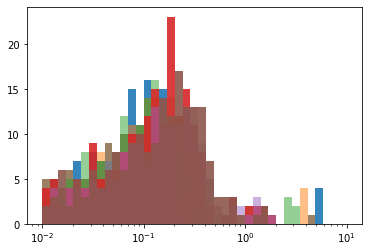

In [103]:
bins = np.logspace(-2, 1, 40)

eig1 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model1_list]))
eig2 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model2_list]))
eig3 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model3_list]))
eig4 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model4_list]))
eig5 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model5_list]))
eig6 = np.real(np.concatenate([choi_spectrum(model.channel) for model in model6_list]))

plt.hist(eig1, bins=bins, alpha=0.9)
plt.hist(eig2, bins=bins, alpha=0.5)
plt.hist(eig3, bins=bins, alpha=0.5)
plt.hist(eig4, bins=bins, alpha=0.9)
plt.hist(eig5, bins=bins, alpha=0.5)
plt.hist(eig6, bins=bins, alpha=0.9)

plt.xscale("log")
plt.show()

In [108]:
R_p1, R_m1, R_pStd1, R_mStd1 = find_outer_inner_R([spectrum1_list[i][:-1] for i in range(5)])
R_p2, R_m2, R_pStd2, R_mStd2 = find_outer_inner_R([spectrum2_list[i][:-1] for i in range(5)])
R_p3, R_m3, R_pStd3, R_mStd3 = find_outer_inner_R([spectrum3_list[i][:-1] for i in range(5)])
R_p4, R_m4, R_pStd4, R_mStd4 = find_outer_inner_R([spectrum4_list[i][:-1] for i in range(5)])
R_p5, R_m5, R_pStd5, R_mStd5 = find_outer_inner_R([spectrum5_list[i][:-1] for i in range(5)])
R_p6, R_m6, R_pStd6, R_mStd6 = find_outer_inner_R([spectrum6_list[i][:-1] for i in range(5)])

In [109]:
x = [0, 5, 10, 15, 20, 25]
R_plus = [R_p1, R_p2, R_p3, R_p4, R_p5, R_p6]
R_minus = [R_m1, R_m2, R_m3, R_m4, R_m5, R_m6]
R_plus_std = [R_pStd1, R_pStd2, R_pStd3, R_pStd4, R_pStd5, R_pStd6]
R_minus_std = [R_mStd1, R_mStd2, R_mStd3, R_mStd4, R_mStd5, R_mStd6]

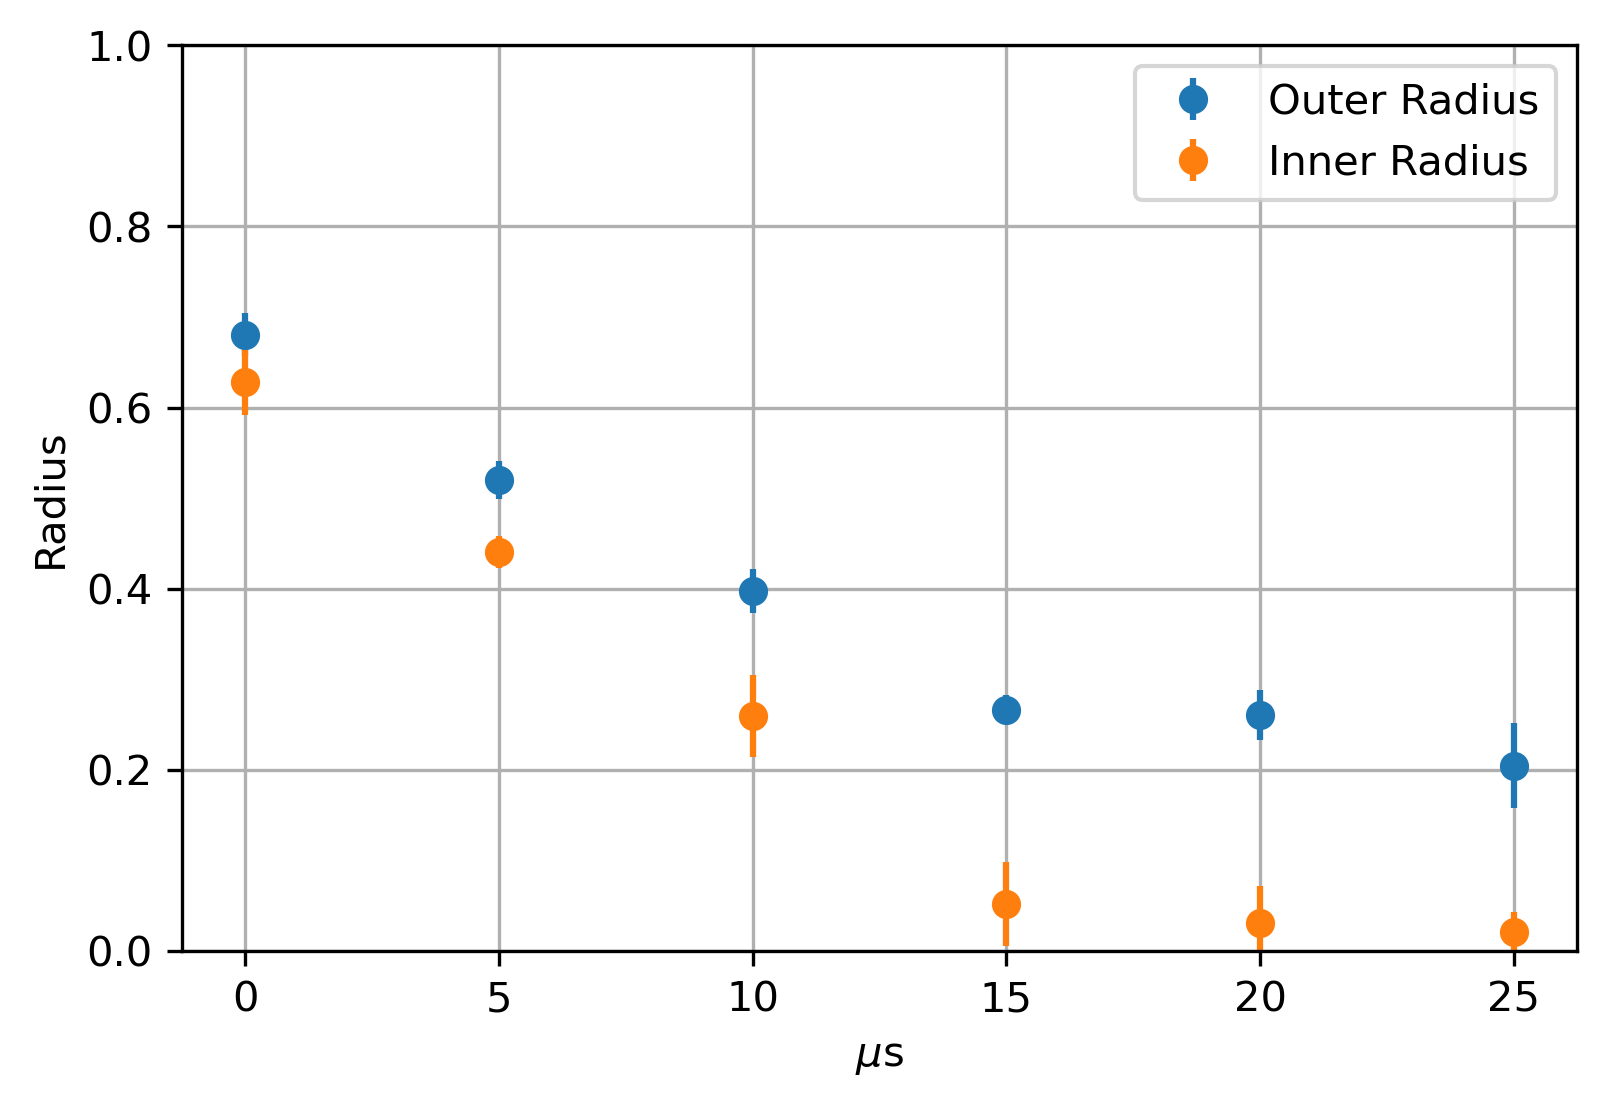

In [110]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')

plt.errorbar(x, R_plus, yerr=R_plus_std, fmt="o")
plt.errorbar(x, R_minus, yerr=R_minus_std, fmt="o")
plt.ylim([0,1])
plt.grid()
plt.xlabel("$\mu$s")
plt.ylabel("Radius")
plt.legend(["Outer Radius", "Inner Radius"])
plt.show()

## Four Qubits

In [114]:
model = fit_model(f"fourQubits_PQC_noDelay_belem", rank=8)

ValueError: too many values to unpack (expected 3)

## Entangling Dissipation

In [5]:
inputs_map, inputs_spam, counts_list =  pickle.load(open(f"../../data/threeQubits_decay_belem.p", "rb"))
n=3
d=2**n


targets_map = counts_to_probs(counts_list[:2000-6**n])
targets_spam = counts_to_probs(counts_list[2000-6**n:])

data = [inputs_spam, targets_spam, inputs_map, targets_map]

inputs_spam, targets_spam, inputs_map, targets_map = data
    
spam = SPAM(d=d, 
            use_corr_mat = True,
            optimizer = tf.optimizers.Adam(learning_rate=0.01),
            )

spam.pretrain(targets = [init_ideal(d), povm_ideal(d)],
              num_iter = 300,
              verbose = False,
              )

spam.train(inputs = inputs_spam,
           targets = targets_spam,
           num_iter = 1000,
           verbose = False,
          )

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=16,
                                               spam = spam,
                                              ),
                           loss_function = ProbabilityMSE(),
                           optimizer = tf.optimizers.Adam(learning_rate=0.01),
                           logger = Logger(loss_function = ProbabilityMSE(), verbose=False),
                           )

model.train(inputs = inputs_map,
            targets = targets_map,
            num_iter = 2000,
            N = 500,
            )  

  0%|          | 0/300 [00:00<?, ?it/s]

9.059889806118323e-05


  0%|          | 0/1000 [00:00<?, ?it/s]

0.010216302971883121


  0%|          | 0/2000 [00:00<?, ?it/s]

0.009233132282428988 None


In [13]:
X, A, B = generate_ginibre(2, 2, trainable=True)
X, C, D = generate_ginibre(2, 2, trainable=True)
X, E, F = generate_ginibre(2, 2, trainable=True)

In [7]:
optimizer = tf.optimizers.Adam(learning_rate=0.01)

for i in range(2000):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch([A,B,C,D,E,F])
        
        
        X1 = tf.cast(A, dtype=precision) + 1j*tf.cast(B, dtype=precision)
        XX1 = tf.matmul(X1, X1, adjoint_b=True)
        state1 = XX1/tf.linalg.trace(XX1)
        
        X2 = tf.cast(C, dtype=precision) + 1j*tf.cast(D, dtype=precision)
        XX2 = tf.matmul(X2, X2, adjoint_b=True)
        state2 = XX2/tf.linalg.trace(XX2)
        
        X3 = tf.cast(E, dtype=precision) + 1j*tf.cast(F, dtype=precision)
        XX3 = tf.matmul(X3, X3, adjoint_b=True)
        state3 = XX3/tf.linalg.trace(XX3)

        
        state = tf.expand_dims(kron(state1,state2,state3), axis=0)

        state = model.channel.apply_channel(state)
        state = partial_transpose(state, qubit=0)

        eig, _ = tf.linalg.eigh(state)
        eig = tf.math.real(eig)
        loss = tf.math.reduce_min(eig) + tf.math.reduce_sum(eig[eig<0]) - tf.math.reduce_min(eig[eig<0])
        grads = tape.gradient(loss, [A,B,C,D,E,F])
        optimizer.apply_gradients(zip(grads, [A,B,C,D,E,F]))
        print(loss.numpy())

-0.12289562705201908
-0.12642606375729662
-0.1298502295909535
-0.13316246612285354
-0.13636012748386533
-0.13944132572892115
-0.14240330494612405
-0.14524335085224582
-0.1479591747991709
-0.15054881812222357
-0.15301079973717957
-0.15534426732385362
-0.15754914410909276
-0.159626195829168
-0.1615770416915094
-0.1634040641934596
-0.1651101975337997
-0.16669870330246458
-0.16817297954743257
-0.1695365195345231
-0.17079303497545106
-0.17194663626624473
-0.17300199369641853
-0.17396437668271314
-0.17483954560902182
-0.17563358792819903
-0.1763527234756108
-0.1770031702200699
-0.1775910349812279
-0.1781222422412044
-0.17860248574931423
-0.17903720622650265
-0.1794315943979059
-0.17979059158692198
-0.18011889465735922
-0.18042095566664187
-0.18070096983215714
-0.1809628472174519
-0.18121017383893828
-0.181446173859854
-0.18167368100426073
-0.18189512986050152
-0.1821125717970449
-0.1823277086704913
-0.18254193500934504
-0.18275637865019134
-0.18297192863590983
-0.18318924836808193
-0.1834087

-0.1995287467423615
-0.1995288199413088
-0.19952889206337282
-0.19952896314209992
-0.1995290331852558
-0.1995291022036455
-0.19952917020644487
-0.19952923722661633
-0.19952930327201057
-0.19952936836281854
-0.1995294325142827
-0.19952949573402226
-0.19952955803916506
-0.19952961946290862
-0.19952967999808383
-0.19952973965723295
-0.1995297984583978
-0.1995298564130126
-0.1995299135508203
-0.19952996986506374
-0.19953002536563297
-0.19953008008720888
-0.1995301340214027
-0.19953018718464827
-0.19953023959514965
-0.19953029125874855
-0.19953034219469734
-0.1995303924079008
-0.19953044190876096
-0.19953049071659393
-0.19953053882403016
-0.19953058625225945
-0.19953063301818527
-0.19953067912891162
-0.19953072458487686
-0.1995307694027955
-0.19953081359858846
-0.199530857172986
-0.19953090013958596
-0.19953094250069855
-0.19953098427345167
-0.19953102545959706
-0.19953106606903484
-0.19953110610950178
-0.1995311455959297
-0.19953118453152568
-0.19953122292373882
-0.19953126077597635
-0.199

-0.19953399767336677
-0.19953399794209517
-0.19953399820646475
-0.19953399846710831
-0.19953399872396055
-0.19953399897717894
-0.1995339992262985
-0.19953399947170192
-0.19953399971370409
-0.19953399995173288
-0.1995340001866644
-0.19953400041775887
-0.19953400064540755
-0.1995340008693403
-0.1995340010900127
-0.19953400130759227
-0.19953400152159068
-0.19953400173290406
-0.19953400194076318
-0.19953400214548672
-0.19953400234715518
-0.19953400254537956
-0.1995340027411377
-0.19953400293339896
-0.19953400312292233
-0.1995340033094968
-0.199534003493522
-0.19953400367434723
-0.19953400385274447
-0.19953400402813123
-0.19953400420125403
-0.19953400437138052
-0.1995340045392835
-0.19953400470429433
-0.19953400486694428
-0.19953400502702245
-0.19953400518465944
-0.1995340053398545
-0.19953400549282496
-0.19953400564307103
-0.19953400579133077
-0.19953400593704024
-0.19953400608072386
-0.19953400622189885
-0.19953400636115695
-0.1995340064984776
-0.1995340066335382
-0.19953400676658833
-0.1

-0.19953401479056404
-0.19953401479075733
-0.19953401479094715
-0.1995340147911344
-0.19953401479131477
-0.19953401479149188
-0.19953401479166674
-0.19953401479183894
-0.19953401479200747
-0.19953401479217692
-0.19953401479233432
-0.19953401479248803
-0.19953401479263902
-0.1995340147927879
-0.19953401479293306
-0.19953401479307545
-0.19953401479321625
-0.19953401479335467
-0.19953401479349078
-0.19953401479362315
-0.1995340147937534
-0.19953401479388252
-0.19953401479401023
-0.19953401479413355
-0.1995340147942544
-0.199534014794374
-0.19953401479448943
-0.1995340147946034
-0.1995340147947152
-0.19953401479481384
-0.19953401479490981
-0.19953401479500726
-0.19953401479510657
-0.199534014795203
-0.19953401479529753
-0.19953401479538596
-0.199534014795479
-0.19953401479556615
-0.19953401479565203
-0.19953401479573635
-0.19953401479581911
-0.19953401479590116
-0.19953401479598257
-0.19953401479606359
-0.19953401479614102
-0.19953401479621868
-0.19953401479629662
-0.19953401479637323
-0.1

-0.19953401479957913
-0.19953401479957894
-0.19953401479957902
-0.1995340147995793
-0.19953401479957902
-0.19953401479957936
-0.1995340147995793
-0.19953401479957902
-0.19953401479957963
-0.1995340147995804
-0.1995340147995806
-0.19953401479958036
-0.19953401479958097
-0.1995340147995807
-0.19953401479958063
-0.19953401479958097
-0.19953401479958094
-0.19953401479958072
-0.19953401479958066
-0.19953401479958083
-0.19953401479958052
-0.199534014799581
-0.199534014799581
-0.19953401479958074
-0.1995340147995807
-0.19953401479958052
-0.199534014799581
-0.19953401479958063
-0.1995340147995806
-0.1995340147995808
-0.1995340147995809
-0.1995340147995806
-0.19953401479958044
-0.19953401479958097
-0.19953401479958108
-0.1995340147995806
-0.19953401479958074
-0.1995340147995808
-0.1995340147995804
-0.19953401479958083
-0.1995340147995809
-0.199534014799581
-0.19953401479958077
-0.1995340147995807
-0.1995340147995806
-0.19953401479958205
-0.19953401479958238
-0.199534014799582
-0.199534014799581

In [8]:
state = kron(state1,state2,state3)

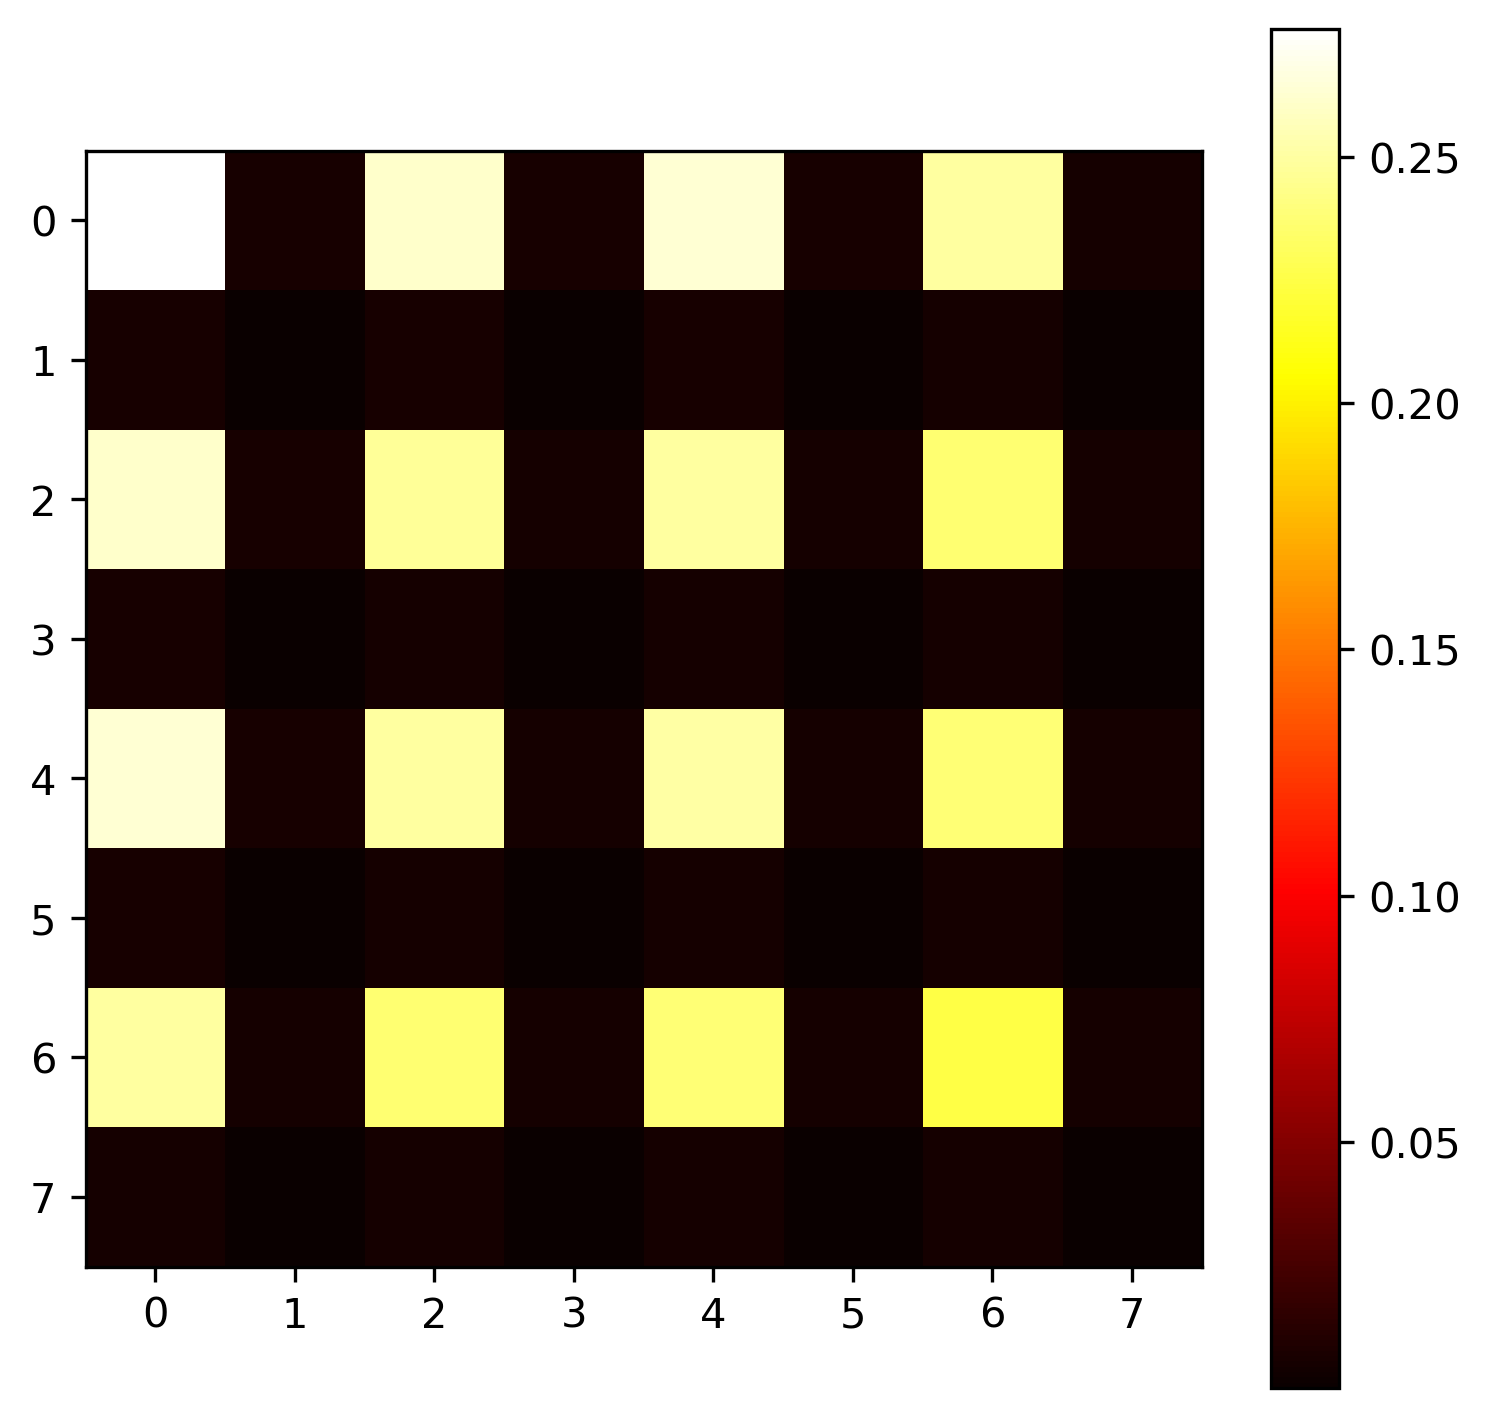

In [9]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

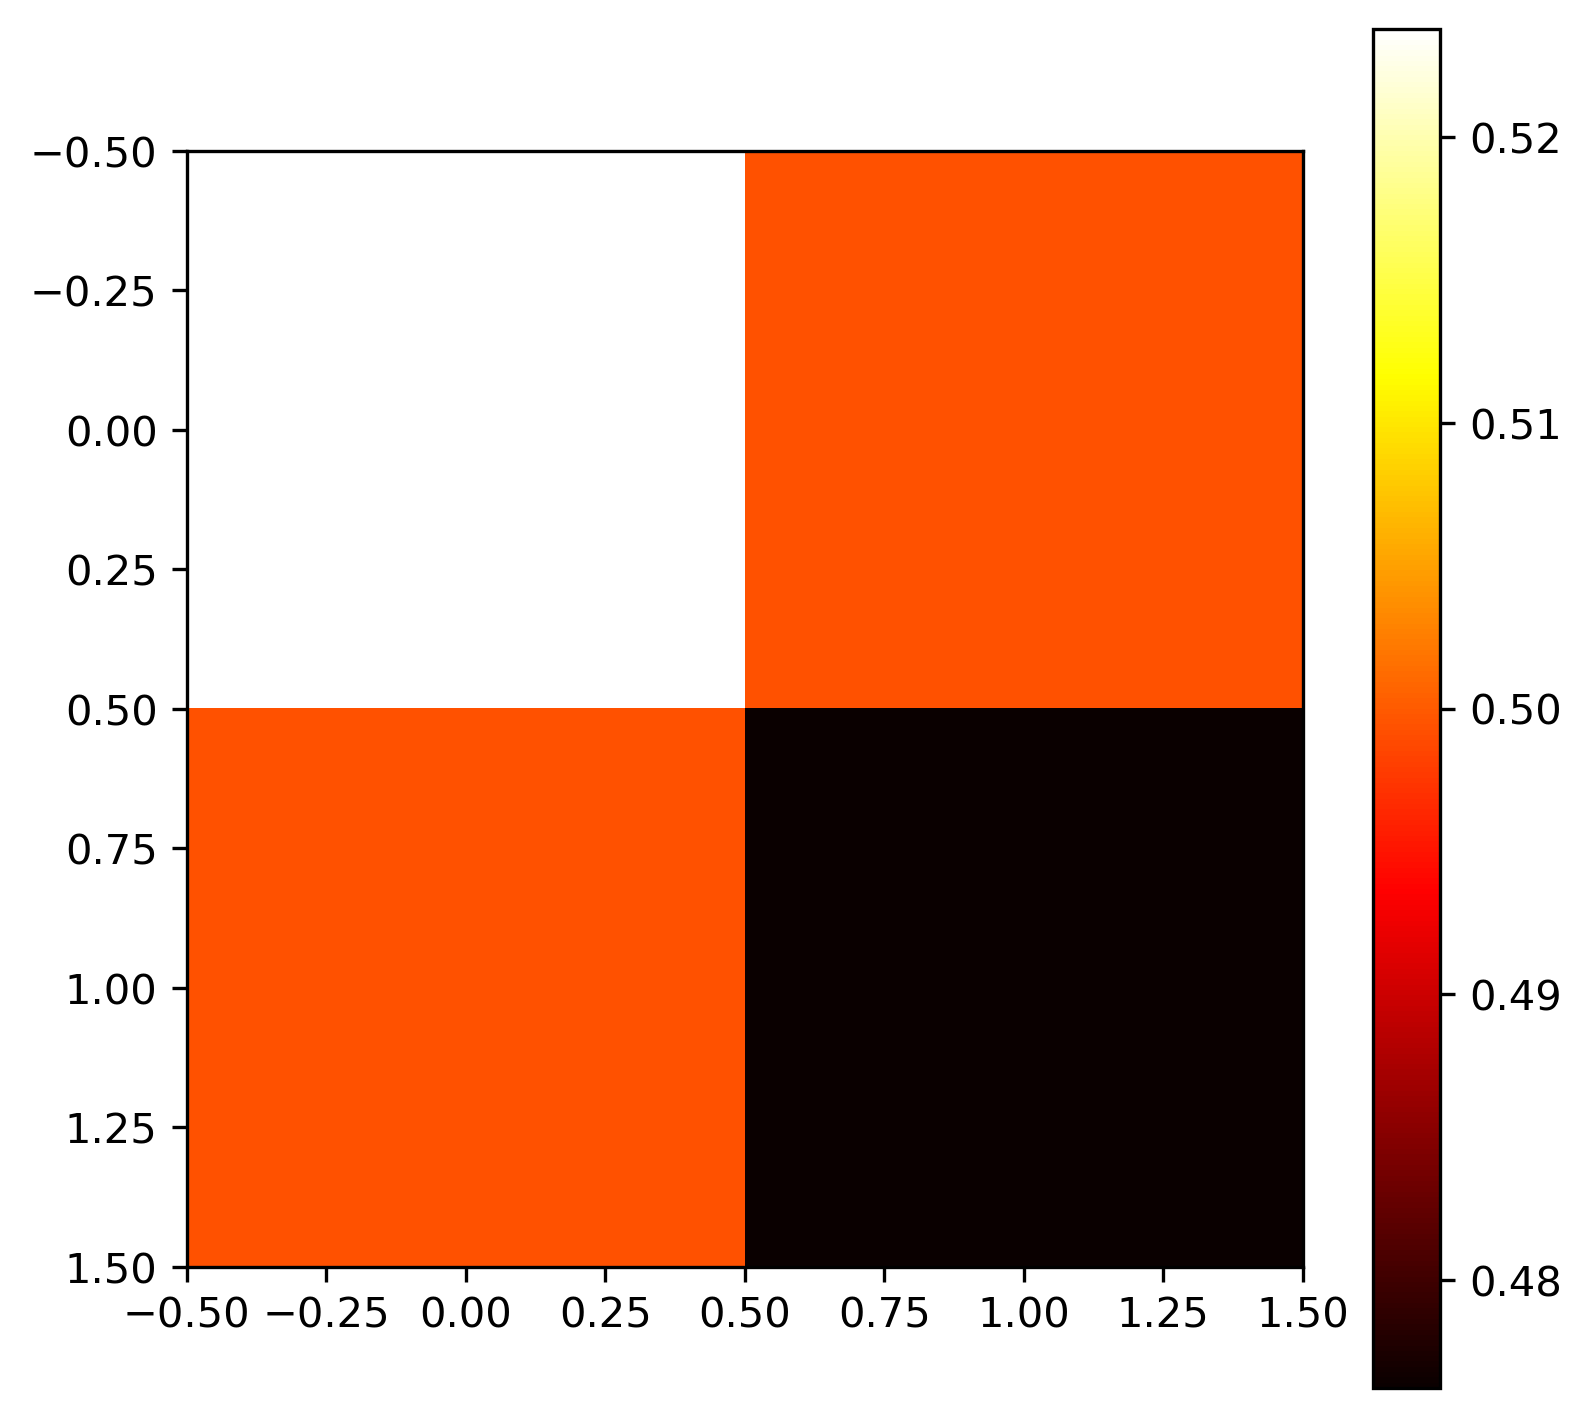

In [10]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state1), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

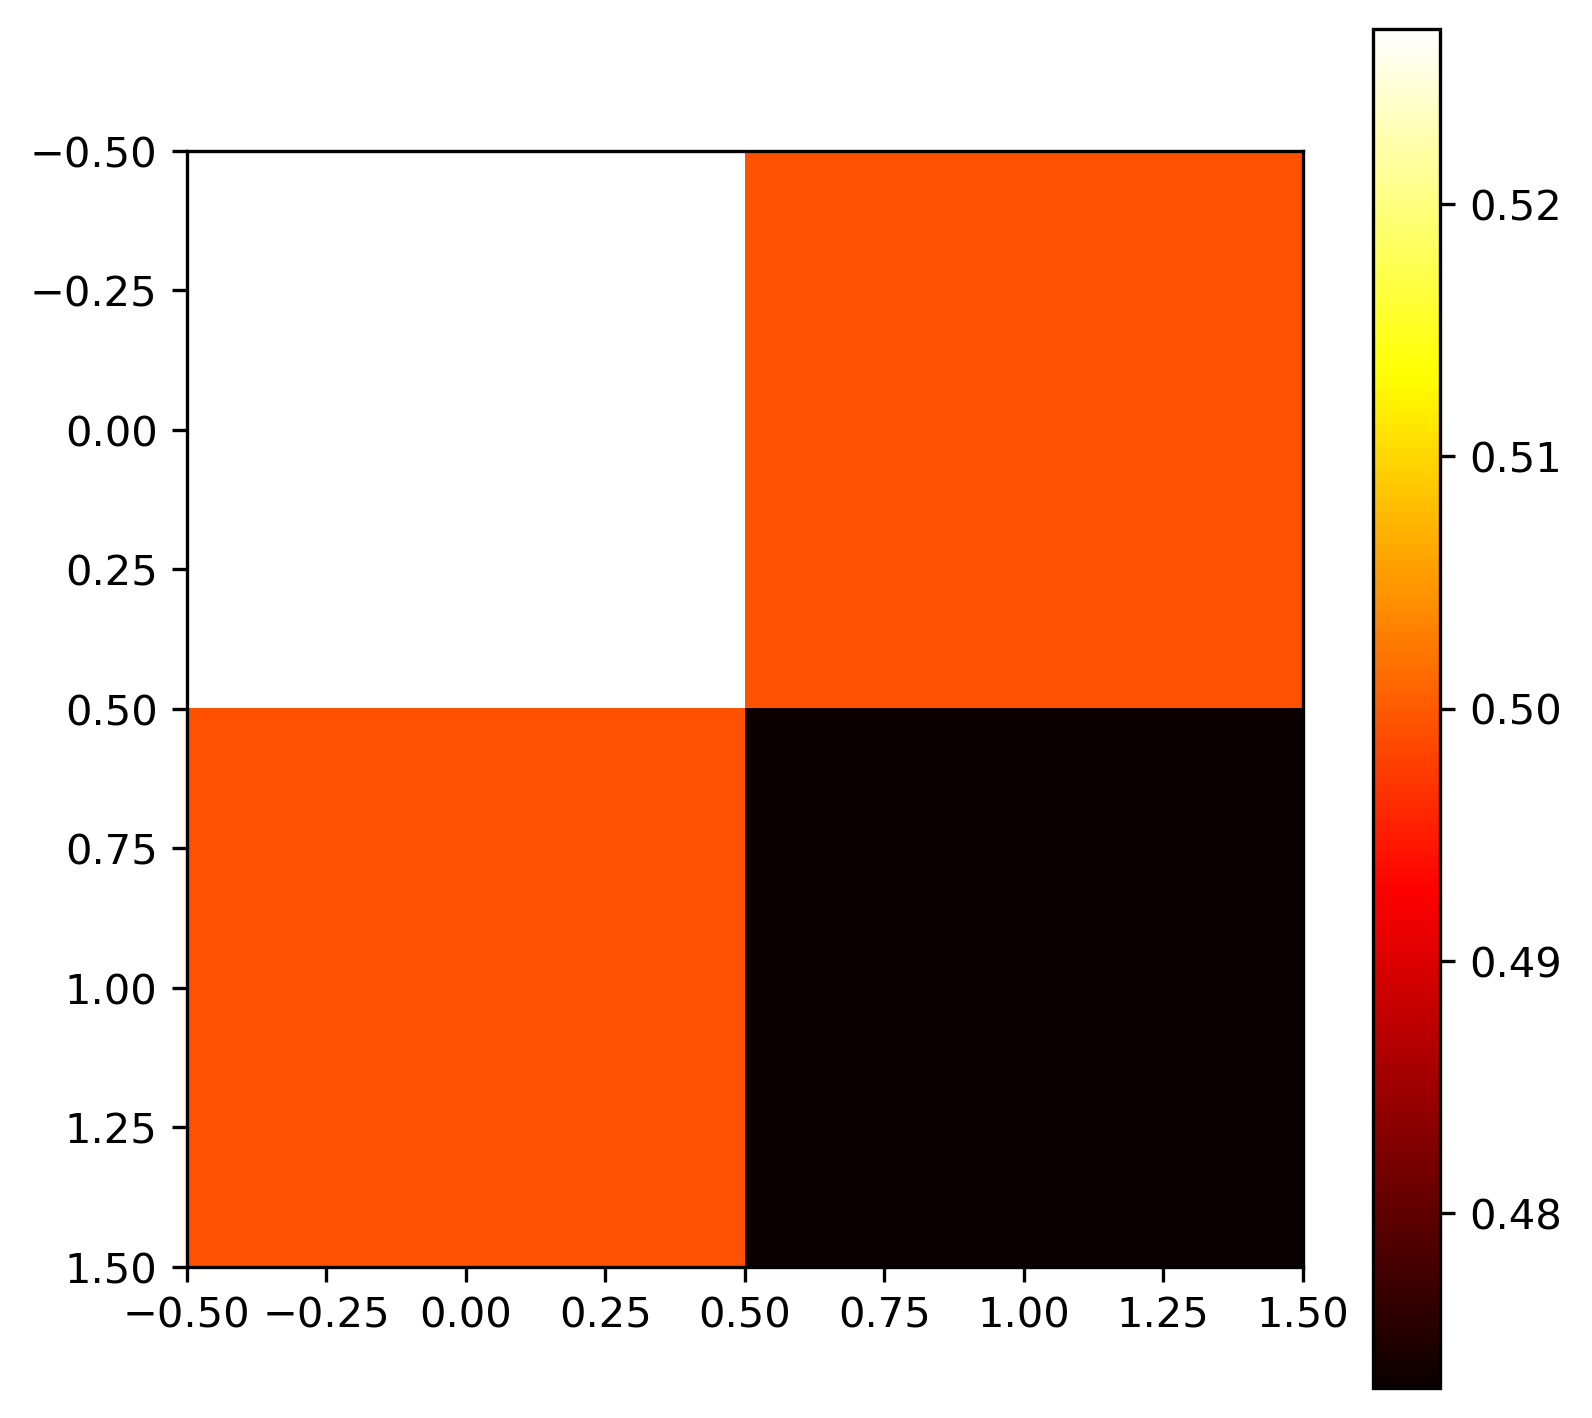

In [11]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state2), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

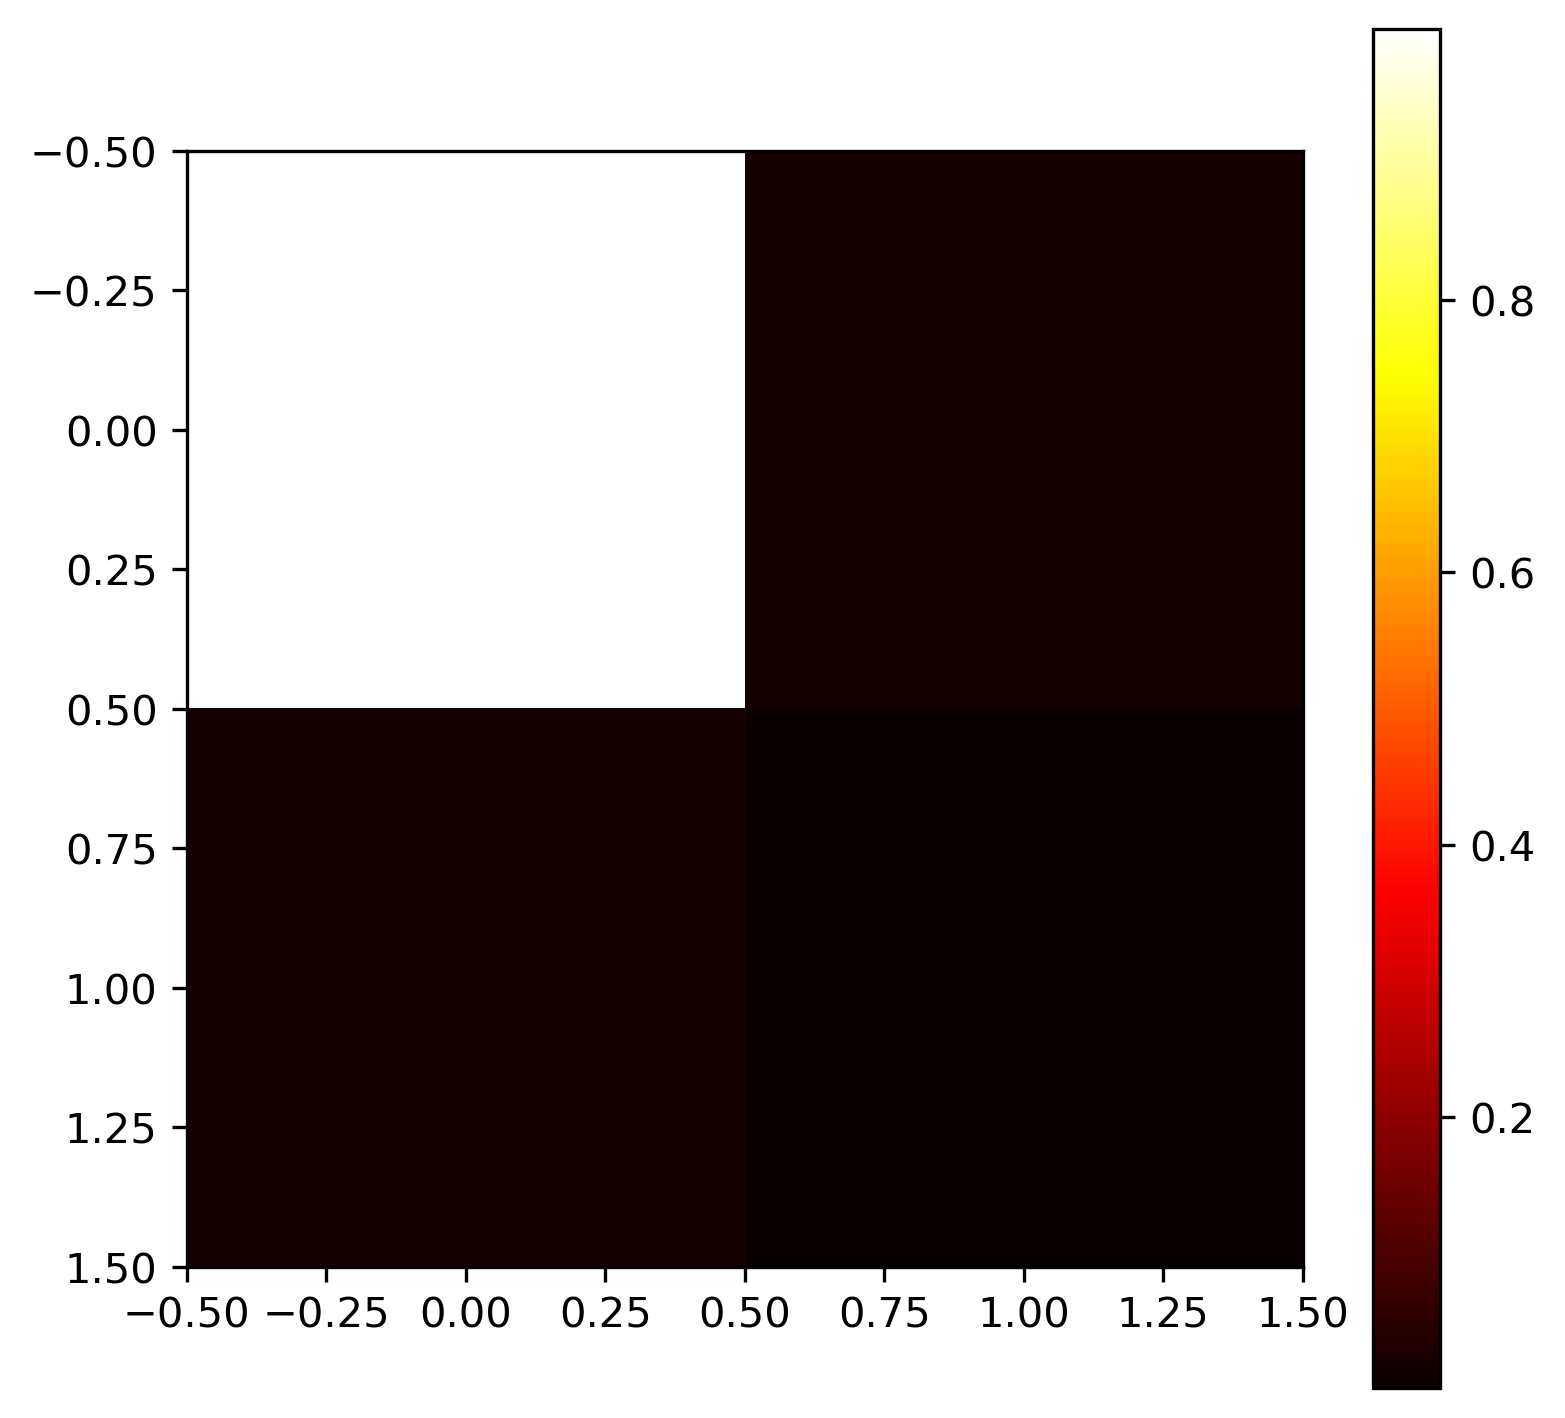

In [12]:
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
plt.imshow(np.abs(state3), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [18]:
N = targets_map.shape[0]
d = model.channel.spam.init.shape[0]
U_prep, U_basis = inputs_map

state = tf.repeat(tf.expand_dims(model.channel.spam.init, axis=0), N, axis=0)
state = apply_unitary(state, U_prep)
state = model.channel.apply_channel(state)
output = measurement(state, U_basis, model.channel.spam.povm)

In [21]:
print(output[1], targets_map[1])

tf.Tensor(
[0.1987+8.6249e-19j 0.1471-1.7798e-18j 0.1063+1.6813e-18j
 0.0768-2.7883e-19j 0.1931+9.6475e-18j 0.1217-1.0601e-18j
 0.083 +1.9314e-18j 0.0761+1.4505e-18j], shape=(8,), dtype=complex128) tf.Tensor(
[0.215+0.j 0.145+0.j 0.107+0.j 0.078+0.j 0.166+0.j 0.129+0.j 0.07 +0.j
 0.09 +0.j], shape=(8,), dtype=complex128)
